In [ ]:
!pip install -q ultralytics

import torch
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import cv2
import numpy as np
import os
from ultralytics import YOLO
from google.colab import drive,files
from pathlib import Path

drive.mount('/content/drive')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 37.0 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Mounted at /content/drive


First We Need To Install and Import all necessary dependencies.

Then We will load our Roboflow YOLO dataset, and use cv2 to preprocess each image. altering the brightness, contrast, hsv.

In [ ]:
CROPS_DIR = "/content/drive/MyDrive/DATASET_FINAL/train/images"

def apply_preprocessing(image):
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)

    l_float = l.astype(np.float32) / 255.0

    highlight_map = cv2.GaussianBlur(l_float, (0,0), sigmaX=30)
    l_float = l_float - (highlight_map * 0.28)
    l_float = np.clip(l_float, 0, 1)

    clahe = cv2.createCLAHE(clipLimit=1.3, tileGridSize=(8,8))
    l_clahe = clahe.apply((l_float * 255).astype(np.uint8))
    l_clahe = (((l_clahe / 255.0) ** 0.95) * 255).astype(np.uint8)

    lab_adjusted = cv2.merge([l_clahe, a, b])
    img_corrected = cv2.cvtColor(lab_adjusted, cv2.COLOR_LAB2BGR)

    hsv = cv2.cvtColor(img_corrected, cv2.COLOR_BGR2HSV).astype(np.float32)
    h, s, v = cv2.split(hsv)
    s = np.clip(s * 1.06, 0, 255)
    hsv_adjusted = cv2.merge([h, s, v]).astype(np.uint8)
    final = cv2.cvtColor(hsv_adjusted, cv2.COLOR_HSV2BGR)

    return final

def preprocess_and_replace(input_folder, backup=True):
    if backup:
        backup_folder = input_folder + "_BACKUP"
        if not os.path.exists(backup_folder):
            os.makedirs(backup_folder, exist_ok=True)
            print(f"📁 Created backup folder: {backup_folder}")

    stats = {
        'total': 0,
        'processed': 0,
        'failed': 0,
        'skipped': 0
    }

    image_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.tiff', '.tif')
    image_files = [f for f in os.listdir(input_folder)
                   if f.lower().endswith(image_extensions)]

    stats['total'] = len(image_files)

    if stats['total'] == 0:
        print(f"⚠️  No images found in {input_folder}")
        return stats

    print(f"\n{'='*60}")
    print(f"PREPROCESSING {stats['total']} IMAGES")
    print(f"{'='*60}\n")

    for i, filename in enumerate(image_files, 1):
        input_path = os.path.join(input_folder, filename)

        try:
            img = cv2.imread(input_path)

            if img is None:
                print(f"❌ [{i}/{stats['total']}] Could not read: {filename}")
                stats['failed'] += 1
                continue

            if backup:
                backup_path = os.path.join(backup_folder, filename)
                cv2.imwrite(backup_path, img)

            processed = apply_preprocessing(img)

            cv2.imwrite(input_path, processed)

            print(f"✅ [{i}/{stats['total']}] Processed: {filename}")
            stats['processed'] += 1

        except Exception as e:
            print(f"❌ [{i}/{stats['total']}] Error processing {filename}: {e}")
            stats['failed'] += 1

    print(f"\n{'='*60}")
    print(f"PROCESSING COMPLETE")
    print(f"{'='*60}")
    print(f"✅ Successfully processed: {stats['processed']}/{stats['total']}")
    print(f"❌ Failed: {stats['failed']}")
    if backup:
        print(f"📁 Original images backed up to: {backup_folder}")
    print(f"{'='*60}\n")

    return stats

stats = preprocess_and_replace(CROPS_DIR, backup=False)

print("\n📷 Sample processed images:")
processed_files = [f for f in os.listdir(CROPS_DIR)
                   if f.lower().endswith(('.png', '.jpg', '.jpeg'))][:5]
for f in processed_files:
    print(f"   - {f}")

print("\n✅ All images in the folder have been preprocessed!")
print(f"📁 Location: {CROPS_DIR}")



PREPROCESSING 442 IMAGES

✅ [1/442] Processed: 1000-16_jpg.rf.3ac546636b555b0ac094afa3ad6492ad.jpg
✅ [2/442] Processed: 148_jpg.rf.30c6f895e346bd950e4b0d634b5fa66b.jpg
✅ [3/442] Processed: 11_jpg.rf.1e88e80df71b1cec10a9828be7456559.jpg
✅ [4/442] Processed: 108_jpg.rf.cf26b108e5e7eb64a3d50313f5e6f21f.jpg
✅ [5/442] Processed: 15-1-_jpg.rf.9e56d623ae980e7df4bdc7b9545d02e8.jpg
✅ [6/442] Processed: 171_jpg.rf.73de97e3e09d97e24824b1201de64172.jpg
✅ [7/442] Processed: 13_jpg.rf.89279c73be7aed69cb49a9df5ab53d78.jpg
✅ [8/442] Processed: 177_jpg.rf.5e1ef9e5d647f46d2c1262e95fbe7789.jpg
✅ [9/442] Processed: 16_jpg.rf.6bb9d1fe6813b4109158cc9203973e12.jpg
✅ [10/442] Processed: 138_jpg.rf.b56db58e78fc1ea7b084e0f8a4a193ca.jpg
✅ [11/442] Processed: 122_jpg.rf.6b785fe44a4b64c2b689ff443d3ba971.jpg
✅ [12/442] Processed: 178_jpg.rf.5f6395dd16ada2afc6eb36f17fc3a562.jpg
✅ [13/442] Processed: 12_jpg.rf.43156a8146ea0da222924ac8c1e4f15d.jpg
✅ [14/442] Processed: 105_jpg.rf.adb2a6f2dcf980fe8fd8cee19fbdc846.jpg


Next, we commence trainint by configuring training parameters and validating the model's metrics, You will need high system RAM and GPU RAM to train this.


In [ ]:
torch.cuda.empty_cache()

dataset_dir="/content/drive/MyDrive/DATASET_FINAL/data.yaml"
save_dir="/content/drive/MyDrive/yolo_nusaaksara3"

def train_max_accuracy():
    model = YOLO("yolov8l.pt")
    results = model.train(
        data=dataset_dir,

        epochs=200,
        patience=30,
        imgsz=1280,
        batch=16,

        device=0,
        amp=True,
        workers=8,
        cache=True,

        lr0=0.0005,
        lrf=0.01,
        warmup_epochs=5.0,

        box=10.0,
        cls=0.5,
        dfl=2.0,
        iou=0.7,

        project=save_dir,
        name="yolov8l_max_accuracy",

        save=True,
        save_period=10,
        verbose=True,
        plots=True,
        val=True,
        seed=42,
        cos_lr=True,
    )

    return results

print("\nStarting auto-selected configuration...")

results = train_max_accuracy()

print(f"\n📁 Results saved to:")
print(f"   /content/drive/MyDrive/DATASET_FINAL/data.yaml")




Starting auto-selected configuration...
Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=10.0, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/content/drive/MyDrive/DATASET_FINAL/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=2.0, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=200, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1280, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0005, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8l.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8l_max_accuracy3, nbs=64, nms=False, opset=None, optimize=Fal

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/yolo_nusaaksara3/yolov8l_max_accuracy/weights/best.pt'

Next we may validate our trained model

In [ ]:

def validate_model(model_path):
    model = YOLO(model_path)

    metrics = model.val(
        data=dataset_dir,
        imgsz=1024,
        batch=16,
        conf=0.25,
        iou=0.6,
        device='cuda' if torch.cuda.is_available() else 'cpu',
        plots=True,
        save_json=True,
    )

    print("\n📊 Validation Metrics:")
    print(f"   mAP50: {metrics.box.map50:.3f}")
    print(f"   mAP50-95: {metrics.box.map:.3f}")
    print(f"   Precision: {metrics.box.mp:.3f}")
    print(f"   Recall: {metrics.box.mr:.3f}")

    return metrics

model_dir="/content/drive/MyDrive/yolo_nusaaksara3/yolov8l_max_accuracy3/weights/best.pt"
validate_model(model_dir)

Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
Model summary (fused): 112 layers, 43,607,379 parameters, 0 gradients, 164.8 GFLOPs
val: Fast image access ✅ (ping: 0.2±0.1 ms, read: 172.0±152.1 MB/s, size: 335.3 KB)
val: Scanning /content/drive/MyDrive/DATASET_FINAL/valid/labels.cache... 50 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 50/50 92.4Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 4/4 1.1it/s 3.8s
                   all         50        700      0.994       0.99      0.994      0.858
Speed: 9.8ms preprocess, 25.3ms inference, 0.0ms loss, 12.1ms postprocess per image
Saving /content/runs/detect/val/predictions.json...
Results saved to /content/runs/detect/val

📊 Validation Metrics:
   mAP50: 0.994
   mAP50-95: 0.858
   Precision: 0.994
   Recall: 0.990


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a7419016630>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

Next, we may visualize metrics from trained YOLO model, based on precision, recall ,map50, map5095.


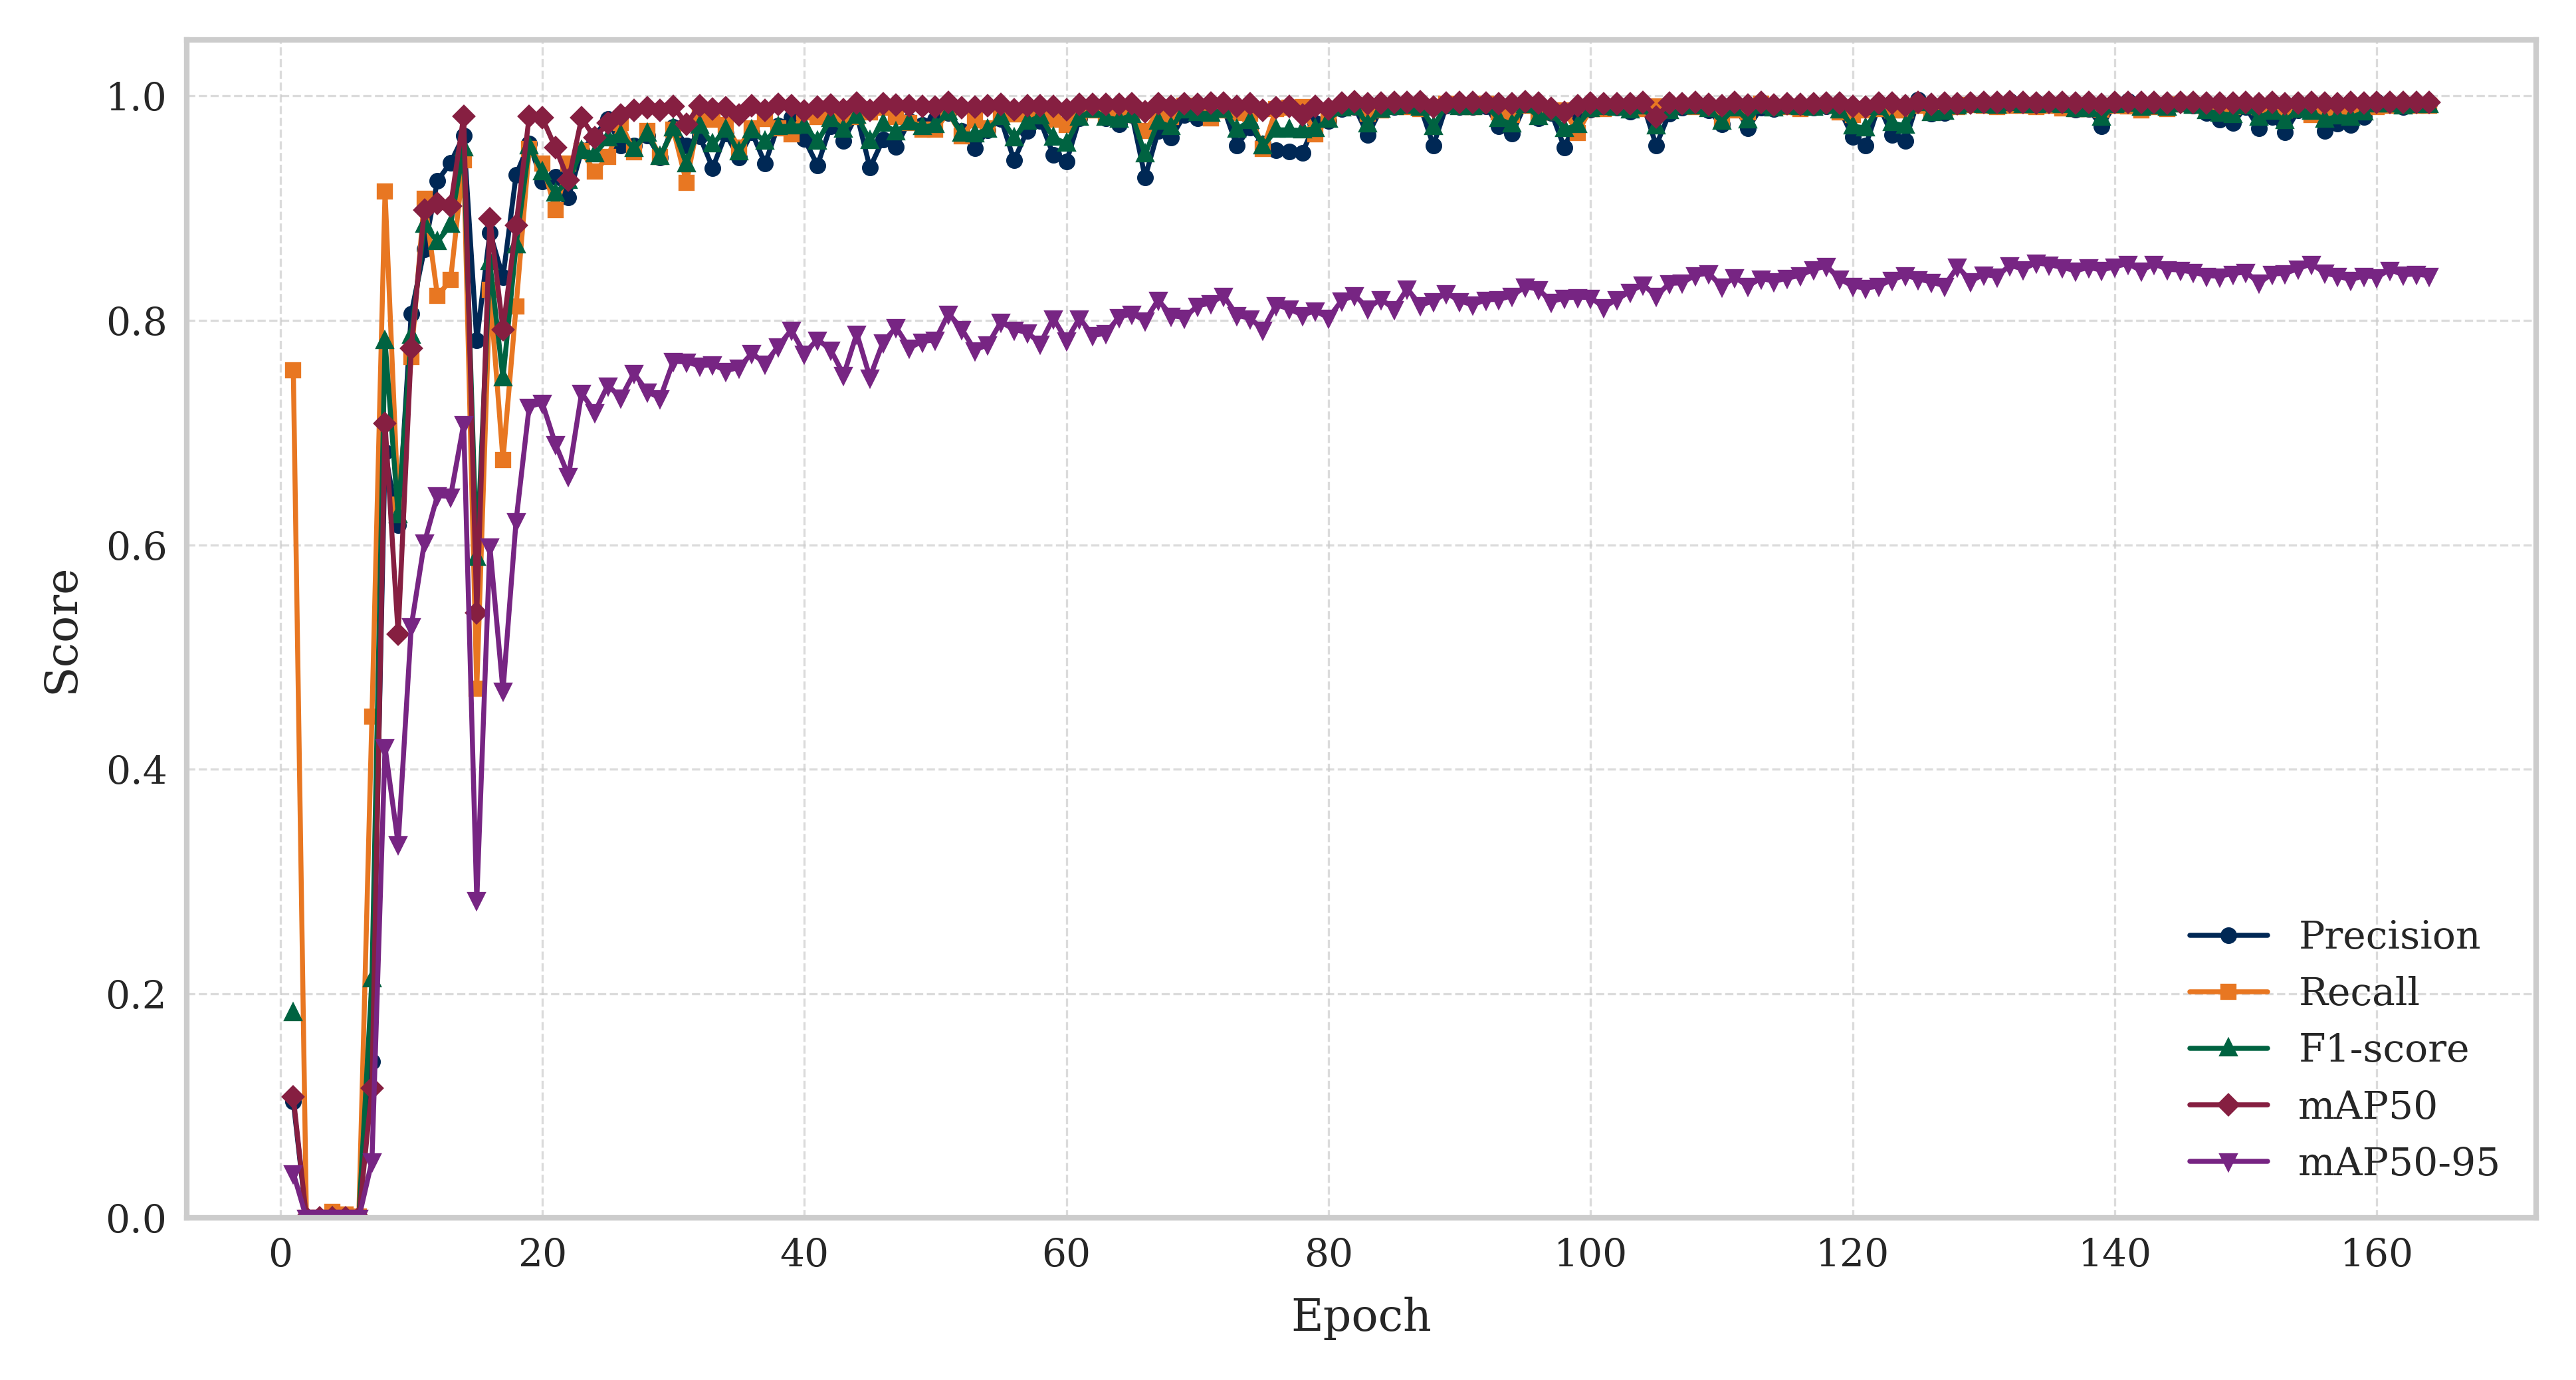

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
csv_path = "/content/drive/MyDrive/yolo_nusaaksara3/yolov8l_max_accuracy3/results.csv"

df = pd.read_csv(csv_path)

df = df.rename(columns={
    "metrics/precision(B)": "precision",
    "metrics/recall(B)": "recall",
    "metrics/mAP50(B)": "map50",
    "metrics/mAP50-95(B)": "map5095"
})

df["f1_score"] = 2 * (df["precision"] * df["recall"]) / (df["precision"] + df["recall"])

plt.style.use('seaborn-v0_8-whitegrid')

plt.figure(figsize=(6.5, 3.5), dpi=600)

plt.rc('font', family='serif', size=8)
plt.rc('axes', labelsize=8, titlesize=8)
plt.rc('legend', fontsize=7)
plt.rc('xtick', labelsize=7)
plt.rc('ytick', labelsize=7)
plt.rc('lines', linewidth=0.9, markersize=2)

plt.grid(True, linestyle="--", linewidth=0.4, alpha=0.7)

plt.plot(df["epoch"], df["precision"], marker='o', color='#002855',  label="Precision")
plt.plot(df["epoch"], df["recall"],    marker='s', color='#E87722', label="Recall")
plt.plot(df["epoch"], df["f1_score"],  marker='^', color='#006341', label="F1-score")
plt.plot(df["epoch"], df["map50"],     marker='D', color='#861F41', label="mAP50")
plt.plot(df["epoch"], df["map5095"],   marker='v', color='#772583', label="mAP50-95")

plt.xlabel("Epoch")
plt.ylabel("Score")
plt.ylim(0, 1.05)

plt.legend(frameon=False, loc="lower right")

plt.tight_layout()

output_path = "YOLO_Metrics_IEEE.png"
plt.savefig(output_path, dpi=600, bbox_inches='tight')
plt.show()

files.download(output_path)


Next, we test our trained model with a sample from our dataset, or any image with jawa dataset.


Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
Model summary (fused): 112 layers, 43,607,379 parameters, 0 gradients, 164.8 GFLOPs
val: Fast image access ✅ (ping: 0.2±0.1 ms, read: 140.4±66.1 MB/s, size: 266.4 KB)
val: Scanning /content/drive/MyDrive/DATASET_FINAL/valid/labels.cache... 50 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 50/50 93.7Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 4/4 1.0s/it 4.1s
                   all         50        700      0.994       0.99      0.994      0.851
Speed: 15.3ms preprocess, 11.2ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to /content/runs/detect/val4
RESULT ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a75670e37a0>
curves: ['Precision

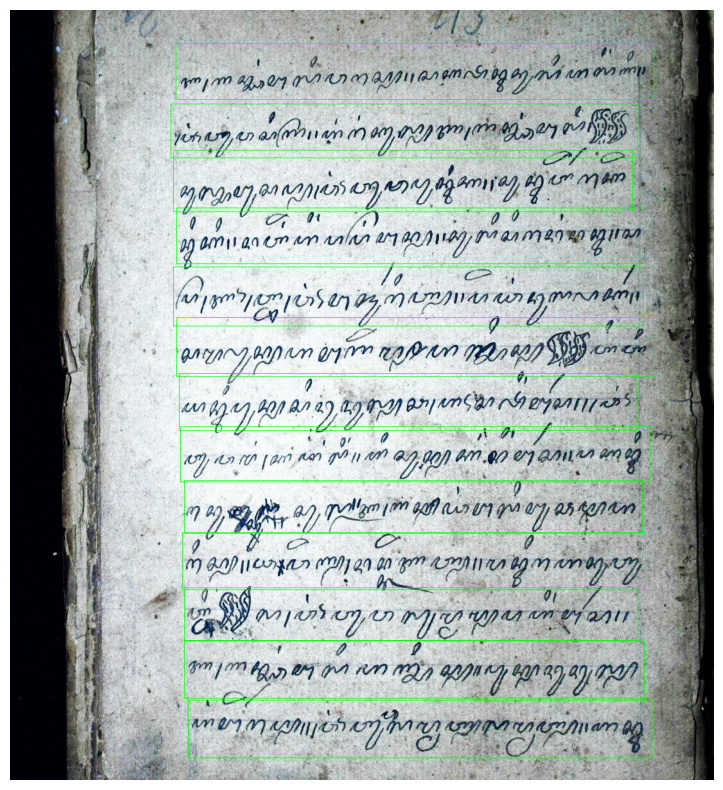

In [ ]:
img_dir="/content/drive/MyDrive/trocr_model_sunda_jawa/valid_test_3.jpg"
dataset_dir="/content/drive/MyDrive/DATASET_FINAL/data.yaml"
model_dir='/content/drive/MyDrive/yolo_nusaaksara3/yolov8l_max_accuracy3/weights/best.pt'

model = YOLO(model_dir)
print("RESULT",model.val())
results = model.predict(img_dir, save=True,conf=0.5, iou=0.7)

res = results[0]

img = cv2.imread(img_dir)

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

for box in res.boxes.xyxy:
    x1, y1, x2, y2 = map(int, box[:4])
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 1)

plt.figure(figsize=(10,10))
plt.imshow(img)
plt.axis("off")
plt.show()


STOP